## Task 3: Multimodal Sarcasm Explanation (MuSE)

References

- [PyTorch MultiheadAttention Documentation](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
- [Shared Fusion Model Paper (Google Drive)](https://drive.google.com/file/d/1mMX4NhoZovPh8pJNbMpmV_EWy43CoBPO/view)
- [NLTK BLEU Score Source Code](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aarzooiiitd_sarcasm_path = kagglehub.dataset_download('aarzooiiitd/sarcasm')

print('Data source import complete.')

100%|██████████| 368M/368M [00:04<00:00, 88.8MB/s]

Extracting files...


Data source import complete.


First, we install the necessary libraries and packages

In [ ]:
%%capture
pip install rouge-score nltk bert-score


In [ ]:
%%capture
pip install bert-score

In [ ]:
%%capture
pip install nltk==3.5

In [ ]:
%%capture
import nltk

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Importing all libraries
import os
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    ViTFeatureExtractor,
    ViTModel,
ViTImageProcessor
)
from transformers.modeling_outputs import BaseModelOutput
from tqdm import tqdm
import math
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from PIL import Image
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings("ignore")

### Dataset Processing

In [ ]:
class MorePlusDataset(Dataset):
    """
    Dataset class. Preprocessing is done in __getitem__().
    """
    def __init__(self, tsv_file, d_pkl, o_pkl, image_dir, tokenizer, max_length=256):
        with open(d_pkl, 'rb') as f:
            self.D = pickle.load(f)  # image descriptions dictionary keyed by pid
        with open(o_pkl, 'rb') as f:
            self.O = pickle.load(f)  # detected objects dictionary keyed by pid
        # Removing all pids which are not present in the pickle files
        valid_pids = set(self.D.keys()) & set(self.O.keys())
        self.df = pd.read_csv(tsv_file, sep='\t')
        self.df = self.df[self.df['pid'].isin(valid_pids)].reset_index(drop=True)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vit_model = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = row['pid']
        text = row['text']
        explanation = row['explanation']
        sarcasm_target = row['target_of_sarcasm']

        # Load image
        image_path = os.path.join(self.image_dir, f"{pid}.jpg")
        image = Image.open(image_path).convert('RGB')

        # Get additional image info from preprocessed pickles
        image_description = self.D.get(pid, "")
        detected_objects = self.O.get(pid, "")

        # Concatenate text as per Section 4.3: [caption] + [image description] + [detected objects] + [sarcasm target]
        # Use a separator token from the BART tokenizer
        separator = self.tokenizer.eos_token
        concatenated_text = f"{text} {separator} {image_description} {separator} {detected_objects} {separator} {sarcasm_target}"
        # Tokenize input and target explanation
        encoding = self.tokenizer(
            concatenated_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            explanation,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        # Preprocessing using VIT Image Processor
        image_input = self.vit_model(images=image, return_tensors='pt')
        return {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "labels": target_encoding.input_ids.squeeze(0),
            "pixel_values": image_input['pixel_values'].squeeze(0)
        }

### Shared Fusion Mechanism

In [ ]:
class SharedFusionLayer(nn.Module):
    def __init__(self):
        super(SharedFusionLayer, self).__init__()
        '''  self.attention represent calculating perform self-attention (Vaswani et al., 2017) on the text and image embeddings
        and equations equation 13 of the Shared Fusion model
        Reference : https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
        '''
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.gate = nn.Linear(768, 768)
        self.alpha1 = nn.Parameter(torch.tensor(0.25))
        self.alpha2 = nn.Parameter(torch.tensor(0.25))
        self.beta1 = nn.Parameter(torch.tensor(0.25))
        self.beta2 = nn.Parameter(torch.tensor(0.25))

    def forward(self, E_t, E_v):
        # Cross-modal attention
        F_vt, _ = self.attention(E_t, E_v, E_v)
        F_tv, _ = self.attention(E_v, E_t, E_t)

        # Resize F_tv to match F_vt's sequence length
        if F_tv.size(1) != F_vt.size(1):
            F_tv = F_tv.transpose(1, 2)
            F_tv = torch.nn.functional.interpolate(F_tv, size=F_vt.size(1), mode='linear', align_corners=False)
            F_tv = F_tv.transpose(1, 2)

        # Gating mechanism
        G_t = torch.sigmoid(self.gate(E_t))
        G_v = torch.sigmoid(self.gate(E_v))

        # Resize G_v to match F_vt's sequence length
        if G_v.size(1) != F_vt.size(1):
            G_v = G_v.transpose(1, 2)
            G_v = torch.nn.functional.interpolate(G_v, size=F_vt.size(1), mode='linear', align_corners=False)
            G_v = G_v.transpose(1, 2)

        # Fusion
        F1 = G_v * F_tv + (1 - G_v) * F_vt
        F2 = G_t * F_tv + (1 - G_t) * F_vt
        F_v = G_v * E_t + (1 - G_v) * F_tv
        F_t = G_t * E_t + (1 - G_t) * F_vt

        F_fused = G_t * F_vt + (1 - G_t) * E_t

        # Final fused encoder representation
        F_sf = (self.alpha1 * F1 +
                self.alpha2 * F2  +
                self.beta1 * F_v +
                self.beta2 * F_t)
        Z = E_t + F_fused
        return Z


### Turbo Model based on BART

In [ ]:
class TurboModel(nn.Module):
    """
    Turbo Model which implements the SharedFusion Layer and passes the output to BART to train
    """
    def __init__(self, bart_model_name='facebook/bart-base', vit_model_name='google/vit-base-patch16-224'):
        super(TurboModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.vit = ViTModel.from_pretrained(vit_model_name)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.bart = BartForConditionalGeneration.from_pretrained(bart_model_name)
        self.tokenizer = BartTokenizer.from_pretrained(bart_model_name)
        self.shared_fusion_layer = SharedFusionLayer()

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Image embeddings
        E_v = self.vit(pixel_values=pixel_values).last_hidden_state
        # Text embeddings
        E_t = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        # Fusion
        F_Sf = self.shared_fusion_layer(E_t, E_v)

        if labels is not None:
            outputs = self.bart(encoder_outputs=(F_Sf,), labels=labels)
            return outputs
        else:
            encoder_outputs = BaseModelOutput(last_hidden_state=F_Sf)
            return self.bart.generate(
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                max_length=50,
                num_beams=4,
                early_stopping=True
            )

    def generate_explanation(self, input_ids, attention_mask, pixel_values, max_length=50):
        E_v = self.vit(pixel_values=pixel_values).last_hidden_state
        E_t = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        Z = self.shared_fusion_layer(E_t, E_v)

        encoder_outputs = BaseModelOutput(last_hidden_state=Z)
        generated_ids = self.bart.generate(
            encoder_outputs=encoder_outputs,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
        return generated_ids

In [ ]:
def compute_metrics(preds, labels):
    """
    Computing all required metrics and returning the dictionary
    """
    # Tokenize predictions and references for BLEU computation
    tokenized_preds = [word_tokenize(pred.lower()) for pred in preds]
    tokenized_refs = [[word_tokenize(ref.lower())] for ref in labels]

    # Compute BLEU scores: BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = corpus_bleu(tokenized_refs, tokenized_preds, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(tokenized_refs, tokenized_preds, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(tokenized_refs, tokenized_preds, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(tokenized_refs, tokenized_preds, weights=(0.25, 0.25, 0.25, 0.25))

    # Compute METEOR: compute individual scores and average them.
    meteor_scores = [meteor_score([ref], pred) for pred, ref in zip(preds, labels)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # Compute ROUGE scores using rouge_score package
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    for pred, ref in zip(preds, labels):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_avg = sum(rouge2_scores) / len(rouge2_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    # Compute BERTScore using bert-score library
    P, R, F1 = bert_score(preds, labels, lang="en", verbose=False)
    bertscore_avg = F1.mean().item()

    return {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "ROUGE-1": rouge1_avg,
        "ROUGE-2": rouge2_avg,
        "ROUGE-L": rougeL_avg,
        "METEOR": meteor_avg,
        "BERTScore Precision": P.mean().item(),
        "BERTScore Recall": R.mean().item(),
        "BERTScore F1": bertscore_avg
    }

In [ ]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        pixel_values = batch["pixel_values"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            pixel_values = batch["pixel_values"].to(device)

            # Forward pass to get loss
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()
            count += 1

            # Generate predictions
            generated_ids = model.generate_explanation(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )
            # Decoding to get sentences
            preds = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            refs = model.tokenizer.batch_decode(labels, skip_special_tokens=True)
            all_preds.extend(preds)
            all_labels.extend(refs)

    avg_loss = total_loss / count
    metrics = compute_metrics(all_preds, all_labels)
    return metrics, all_preds, all_labels, avg_loss

In [ ]:
# Set up paths
train_tsv = aarzooiiitd_sarcasm_path  + '/' + "train_df.tsv"
val_tsv = aarzooiiitd_sarcasm_path  + '/' + "val_df.tsv"
d_train_pkl = aarzooiiitd_sarcasm_path  + '/' + "D_train.pkl"
o_train_pkl = aarzooiiitd_sarcasm_path  + '/' + "O_train.pkl"
d_val_pkl = aarzooiiitd_sarcasm_path  + '/' + "D_val.pkl"
o_val_pkl = aarzooiiitd_sarcasm_path  + '/' + "O_val.pkl"
image_dir = aarzooiiitd_sarcasm_path  + '/' + "images-20250401T152822Z-001/images"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer and feature extractor from BART and ViT
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Create datasets and dataloaders
train_dataset = MorePlusDataset(train_tsv, d_train_pkl, o_train_pkl, image_dir, tokenizer)
val_dataset = MorePlusDataset(val_tsv, d_val_pkl, o_val_pkl, image_dir, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
model = TurboModel()
model.to(device)

# Set up optimizer (using different LR for different parts if needed)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 10

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')
    print("Created directory model_checkpoints")

Created directory model_checkpoints


In [ ]:
train_losses = []
val_losses = []

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Training Loss: {train_loss:.4f}")
    train_losses.append(train_loss)
    # Save model checkpoint after each epoch
    checkpoint_path = f"model_checkpoints/turbo_epoch{epoch+1}.pt"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

    # Evaluate on validation set
    metrics, preds, refs, val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    print("Validation Metrics:", metrics)
    if (epoch == num_epochs - 1):
        with open(f"val_explanations_epoch{epoch+1}.txt", "w") as f:
            for i in range(10):
                f.write("Reference Text: " + refs[i] + "\n")
                f.write("Predicted Text: " + preds[i] + "\n")
                f.write("\n")

Epoch 1/10


Training: 100%|██████████| 315/315 [04:47<00:00,  1.10it/s]


Training Loss: 4.5802
Saved checkpoint: model_checkpoints/turbo_epoch1.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.3719
Validation Metrics: {'BLEU-1': 0.4629261418884106, 'BLEU-2': 0.37696989793778596, 'BLEU-3': 0.32187051749610684, 'BLEU-4': 0.2760521828645803, 'ROUGE-1': 0.47883660683558, 'ROUGE-2': 0.31816568085753494, 'ROUGE-L': 0.46017428601455507, 'METEOR': 0.36648522636138414, 'BERTScore Precision': 0.879865288734436, 'BERTScore Recall': 0.8770987391471863, 'BERTScore F1': 0.8781840801239014}
Epoch 2/10


Training: 100%|██████████| 315/315 [04:39<00:00,  1.13it/s]


Training Loss: 0.3303
Saved checkpoint: model_checkpoints/turbo_epoch2.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1746
Validation Metrics: {'BLEU-1': 0.4901563425619773, 'BLEU-2': 0.4016758853625153, 'BLEU-3': 0.3461498664087722, 'BLEU-4': 0.2996985555505869, 'ROUGE-1': 0.5085971644329733, 'ROUGE-2': 0.3435467436266168, 'ROUGE-L': 0.48116714577482567, 'METEOR': 0.38726003772742507, 'BERTScore Precision': 0.9113345742225647, 'BERTScore Recall': 0.9034753441810608, 'BERTScore F1': 0.9071275591850281}
Epoch 3/10


Training: 100%|██████████| 315/315 [04:36<00:00,  1.14it/s]


Training Loss: 0.1980
Saved checkpoint: model_checkpoints/turbo_epoch3.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1580
Validation Metrics: {'BLEU-1': 0.48138339395917473, 'BLEU-2': 0.39619397189997, 'BLEU-3': 0.34182477613655216, 'BLEU-4': 0.2960909301233198, 'ROUGE-1': 0.5031153810782941, 'ROUGE-2': 0.33491542994695317, 'ROUGE-L': 0.479165832788216, 'METEOR': 0.38924539540508635, 'BERTScore Precision': 0.9135168790817261, 'BERTScore Recall': 0.9039142727851868, 'BERTScore F1': 0.9084537029266357}
Epoch 4/10


Training: 100%|██████████| 315/315 [04:37<00:00,  1.14it/s]


Training Loss: 0.1641
Saved checkpoint: model_checkpoints/turbo_epoch4.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1369
Validation Metrics: {'BLEU-1': 0.5083402365680324, 'BLEU-2': 0.41920582684734975, 'BLEU-3': 0.36190265643929737, 'BLEU-4': 0.3132269515604447, 'ROUGE-1': 0.5278494578805831, 'ROUGE-2': 0.36486064110749783, 'ROUGE-L': 0.494218145816636, 'METEOR': 0.4137022800775351, 'BERTScore Precision': 0.9178861975669861, 'BERTScore Recall': 0.9095094203948975, 'BERTScore F1': 0.9134642481803894}
Epoch 5/10


Training: 100%|██████████| 315/315 [04:36<00:00,  1.14it/s]


Training Loss: 0.1427
Saved checkpoint: model_checkpoints/turbo_epoch5.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1284
Validation Metrics: {'BLEU-1': 0.5216697218444206, 'BLEU-2': 0.4374150629041245, 'BLEU-3': 0.38210733555918763, 'BLEU-4': 0.33404492646046413, 'ROUGE-1': 0.5299052001318139, 'ROUGE-2': 0.37725306697747113, 'ROUGE-L': 0.4994322905566597, 'METEOR': 0.42796839930869607, 'BERTScore Precision': 0.9196717143058777, 'BERTScore Recall': 0.911685585975647, 'BERTScore F1': 0.9154557585716248}
Epoch 6/10


Training: 100%|██████████| 315/315 [04:36<00:00,  1.14it/s]


Training Loss: 0.1298
Saved checkpoint: model_checkpoints/turbo_epoch6.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1235
Validation Metrics: {'BLEU-1': 0.518476133554367, 'BLEU-2': 0.43764303015599293, 'BLEU-3': 0.3866361075661891, 'BLEU-4': 0.3420209051127739, 'ROUGE-1': 0.5336406807659194, 'ROUGE-2': 0.38549840774352506, 'ROUGE-L': 0.5114144417177975, 'METEOR': 0.4308216278618235, 'BERTScore Precision': 0.9228239059448242, 'BERTScore Recall': 0.9124187231063843, 'BERTScore F1': 0.9173898100852966}
Epoch 7/10


Training: 100%|██████████| 315/315 [04:37<00:00,  1.14it/s]


Training Loss: 0.1209
Saved checkpoint: model_checkpoints/turbo_epoch7.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1189
Validation Metrics: {'BLEU-1': 0.5349350447465363, 'BLEU-2': 0.4520309289389566, 'BLEU-3': 0.39852037577148874, 'BLEU-4': 0.3522825790763408, 'ROUGE-1': 0.5409927222963142, 'ROUGE-2': 0.38806521859239895, 'ROUGE-L': 0.5180854701949186, 'METEOR': 0.44296444774721294, 'BERTScore Precision': 0.9250602722167969, 'BERTScore Recall': 0.9151489734649658, 'BERTScore F1': 0.919858992099762}
Epoch 8/10


Training: 100%|██████████| 315/315 [04:37<00:00,  1.13it/s]


Training Loss: 0.1122
Saved checkpoint: model_checkpoints/turbo_epoch8.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1156
Validation Metrics: {'BLEU-1': 0.5450143134719282, 'BLEU-2': 0.4617035139604815, 'BLEU-3': 0.40852466904287926, 'BLEU-4': 0.3619038389657191, 'ROUGE-1': 0.5465610258846226, 'ROUGE-2': 0.3915893447275643, 'ROUGE-L': 0.5232968592598605, 'METEOR': 0.4479438555295153, 'BERTScore Precision': 0.9241625070571899, 'BERTScore Recall': 0.9163749814033508, 'BERTScore F1': 0.9200149774551392}
Epoch 9/10


Training: 100%|██████████| 315/315 [04:38<00:00,  1.13it/s]


Training Loss: 0.1055
Saved checkpoint: model_checkpoints/turbo_epoch9.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1125
Validation Metrics: {'BLEU-1': 0.5630849615380769, 'BLEU-2': 0.4771368548076897, 'BLEU-3': 0.4220954663170926, 'BLEU-4': 0.3740293841651546, 'ROUGE-1': 0.5599441769393023, 'ROUGE-2': 0.40527258923934456, 'ROUGE-L': 0.5362022665417107, 'METEOR': 0.4705766656968886, 'BERTScore Precision': 0.9262163639068604, 'BERTScore Recall': 0.9192990064620972, 'BERTScore F1': 0.9225054979324341}
Epoch 10/10


Training: 100%|██████████| 315/315 [04:37<00:00,  1.13it/s]


Training Loss: 0.0983
Saved checkpoint: model_checkpoints/turbo_epoch10.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 0.1101
Validation Metrics: {'BLEU-1': 0.5519632281472142, 'BLEU-2': 0.47184157546324434, 'BLEU-3': 0.4195082366510512, 'BLEU-4': 0.3729495911415091, 'ROUGE-1': 0.5568063083957235, 'ROUGE-2': 0.40541958157948194, 'ROUGE-L': 0.5322956650018713, 'METEOR': 0.46052634981972435, 'BERTScore Precision': 0.9268147349357605, 'BERTScore Recall': 0.9179215431213379, 'BERTScore F1': 0.922130823135376}


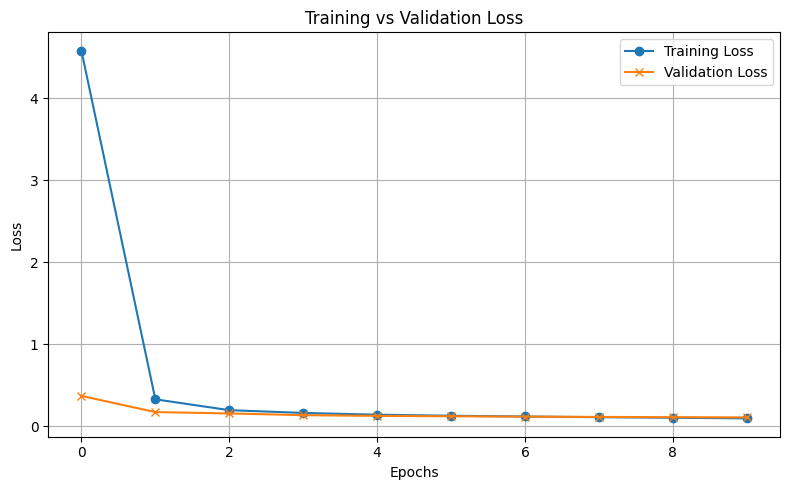

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Due to large size of model checkpoints, we have shared the Google Drive link for all the model checkpoints saved after each epoch:
[Model Checkpoints](https://drive.google.com/drive/folders/1nbtbUeArKHvQNIDHlnNYGfG1WWA-PHYw?usp=sharing)

### Testing and Model Inference

In [ ]:
def run_inference_and_evaluate(test_tsv, d_test_pkl, o_test_pkl, image_dir,checkpoint_path, output_file="test_predictions.txt"):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load tokenizer and model
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = TurboModel()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Load test dataset
    test_dataset = MorePlusDataset(test_tsv, d_test_pkl, o_test_pkl, image_dir, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    all_preds = []
    all_refs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Inference", unit="batch"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Generate predictions
            generated_ids = model.generate_explanation(input_ids, attention_mask, pixel_values)
            preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

            all_preds.extend(preds)
            all_refs.extend(refs)

    # Save predictions
    with open(output_file, "w") as f:
        for ref, pred in zip(all_refs, all_preds):
            f.write("Reference: " + ref.strip() + "\n")
            f.write("Prediction: " + pred.strip() + "\n")
            f.write("\n")

    # Compute and return metrics
    metrics = compute_metrics(all_preds, all_refs)
    print("Evaluation Metrics:")
    for key, val in metrics.items():
        print(f"{key}: {val:.4f}")

    return metrics, all_preds, all_refs


In [ ]:
path = aarzooiiitd_sarcasm_path + '/'

metrics, predictions, references = run_inference_and_evaluate(
    test_tsv= path + "val_df.tsv",
    d_test_pkl= path + "D_val.pkl",
    o_test_pkl= path + "O_val.pkl",
    image_dir= path + "images-20250401T152822Z-001/images",
    checkpoint_path="model_checkpoints/turbo_epoch10.pt",
    output_file="test_predictions.txt"
)
